<a href="https://colab.research.google.com/github/ahmad3006/satellite-tracking/blob/main/sattracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install skyfield


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 18.8 MB/s eta 0:00:00


In [3]:
from skyfield.api import load, EarthSatellite

In [4]:
url = 'https://celestrak.org/NORAD/elements/stations.txt'
satellites = load.tle_file(url)
print(f'Downloaded {len(satellites)} satellites')

[#################################] 100% stations.txt


Downloaded 13 satellites


In [6]:
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['TIANZHOU-8']

In [7]:
from datetime import datetime
from skyfield.api import wgs84

ts = load.timescale()
t = ts.now()  # atau bisa pakai ts.utc(2025, 5, 23, 15, 0) untuk waktu spesifik

In [8]:
observer_location = wgs84.latlon(-7.9666, 112.6326)


In [9]:
difference = satellite - observer_location
topocentric = difference.at(t)
alt, az, distance = topocentric.altaz()

print(f'Altitude: {alt.degrees:.2f}°')
print(f'Azimuth: {az.degrees:.2f}°')
print(f'Distance: {distance.km:.2f} km')

Altitude: -53.47°
Azimuth: 264.75°
Distance: 10721.08 km


In [10]:
geocentric = satellite.at(t)
subpoint = geocentric.subpoint()
print(f'Latitude: {subpoint.latitude.degrees:.2f}')
print(f'Longitude: {subpoint.longitude.degrees:.2f}')
print(f'Elevation: {subpoint.elevation.km:.2f} km')

Latitude: -2.24
Longitude: 2.77
Elevation: 383.62 km


In [14]:
from skyfield.api import load

In [16]:
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=iridium-33-debris&FORMAT=tle'
satellites = load.tle_file(url)
print(f'Downloaded {len(satellites)} satellites')

[#################################] 100% gp.php


Downloaded 116 satellites


In [17]:
iridium_33 = None
for sat in satellites:
    if 'IRIDIUM 33' in sat.name.upper():
        iridium_33 = sat
        break


In [18]:
if iridium_33:
    print("Found:", iridium_33.name)
    print(iridium_33)
else:
    print("Iridium 33 not found in this TLE set.")

Found: IRIDIUM 33
IRIDIUM 33 catalog #24946 epoch 2025-05-22 12:39:36 UTC


In [19]:
line1 = "1 24946U 97051C   24143.50347225  .00000096  00000+0  57079-4 0  9993"
line2 = "2 24946  86.3910 167.2371 0003217  88.5513 271.5999 14.63590009814641"
name = "IRIDIUM 33"

In [20]:
iridium_33 = EarthSatellite(line1, line2, name)
ts = load.timescale()
t = ts.now()

In [21]:
geocentric = iridium_33.at(t)
subpoint = geocentric.subpoint()

In [22]:
print("\n3. From manual TLE (CATNR):")
print(f'Lat: {subpoint.latitude.degrees:.2f}')
print(f'Lon: {subpoint.longitude.degrees:.2f}')
print(f'Alt: {subpoint.elevation.km:.2f} km')


3. From manual TLE (CATNR):
Lat: -52.77
Lon: 8.55
Alt: 699.51 km


In [23]:
pip install skyfield numpy matplotlib


RuntimeError: x must be a sequence

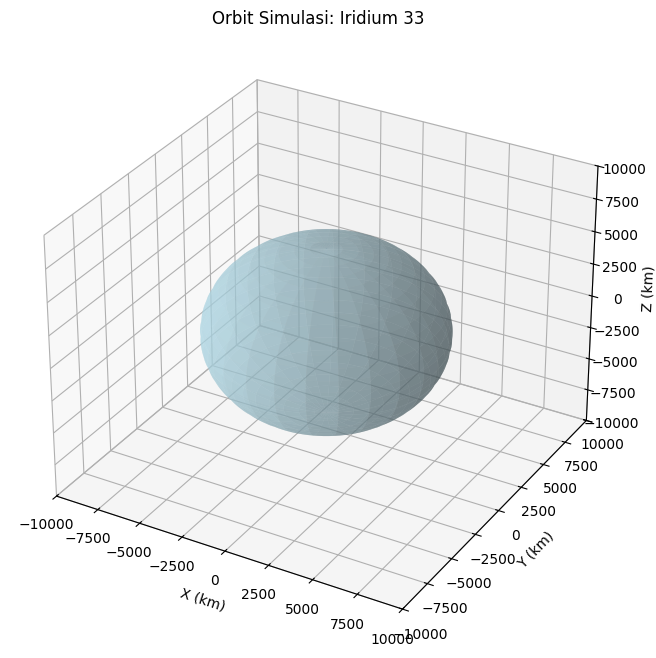

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from skyfield.api import load, EarthSatellite

# TLE IRIDIUM 33 (bisa di-update dengan yang terbaru)
line1 = "1 24946U 97051C   24143.50347225  .00000096  00000+0  57079-4 0  9993"
line2 = "2 24946  86.3910 167.2371 0003217  88.5513 271.5999 14.63590009814641"
satellite = EarthSatellite(line1, line2, 'IRIDIUM 33')
ts = load.timescale()

# Waktu simulasi (90 menit = 1 orbit penuh)
minutes = np.arange(0, 90, 1)
times = ts.utc(2024, 5, 23, 0, minutes)

# Ambil posisi XYZ satelit dari pusat Bumi
positions = satellite.at(times).position.km

# Buat figure 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Orbit Simulasi: Iridium 33')

# Gambar Bumi (bola)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
earth_x = 6371 * np.outer(np.cos(u), np.sin(v))
earth_y = 6371 * np.outer(np.sin(u), np.sin(v))
earth_z = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(earth_x, earth_y, earth_z, rstride=4, cstride=4, color='lightblue', alpha=0.5)

# Inisialisasi titik satelit
satellite_dot, = ax.plot([], [], [], 'ro', label='Iridium 33')
path_line, = ax.plot([], [], [], 'r--', linewidth=0.5, alpha=0.7)

# Set axis limit
limit = 10000  # km
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')

# Animasi update
def update(frame):
    satellite_dot.set_data(positions[0][frame], positions[1][frame])
    satellite_dot.set_3d_properties(positions[2][frame])

    path_line.set_data(positions[0][:frame], positions[1][:frame])
    path_line.set_3d_properties(positions[2][:frame])

    return satellite_dot, path_line

ani = FuncAnimation(fig, update, frames=len(minutes), interval=100, blit=True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
def update(frame):
    x = positions[0][frame].item()
    y = positions[1][frame].item()
    z = positions[2][frame].item()

    satellite_dot.set_data([x], [y])
    satellite_dot.set_3d_properties([z])

    path_line.set_data(positions[0][:frame], positions[1][:frame])
    path_line.set_3d_properties(positions[2][:frame])

    return satellite_dot, path_line


Text(0.5, 0, 'Z (km)')

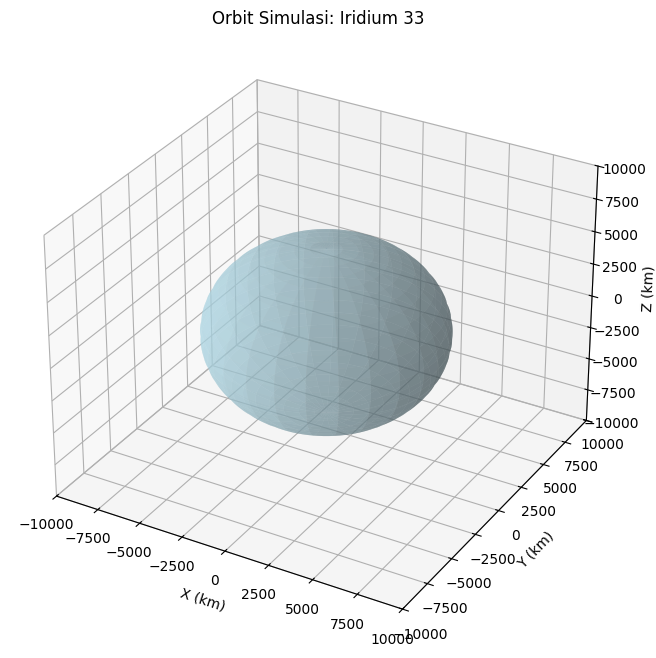

In [26]:
# TLE IRIDIUM 33 (bisa di-update dengan yang terbaru)
line1 = "1 24946U 97051C   24143.50347225  .00000096  00000+0  57079-4 0  9993"
line2 = "2 24946  86.3910 167.2371 0003217  88.5513 271.5999 14.63590009814641"
satellite = EarthSatellite(line1, line2, 'IRIDIUM 33')
ts = load.timescale()

# Waktu simulasi (90 menit = 1 orbit penuh)
minutes = np.arange(0, 90, 1)
times = ts.utc(2024, 5, 23, 0, minutes)

# Ambil posisi XYZ satelit dari pusat Bumi
positions = satellite.at(times).position.km

# Buat figure 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Orbit Simulasi: Iridium 33')

# Gambar Bumi (bola)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
earth_x = 6371 * np.outer(np.cos(u), np.sin(v))
earth_y = 6371 * np.outer(np.sin(u), np.sin(v))
earth_z = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(earth_x, earth_y, earth_z, rstride=4, cstride=4, color='lightblue', alpha=0.5)

# Inisialisasi titik satelit
satellite_dot, = ax.plot([], [], [], 'ro', label='Iridium 33')
path_line, = ax.plot([], [], [], 'r--', linewidth=0.5, alpha=0.7)

# Set axis limit
limit = 10000  # km
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')

<ipython-input-27-4a0b0d3cec3c>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


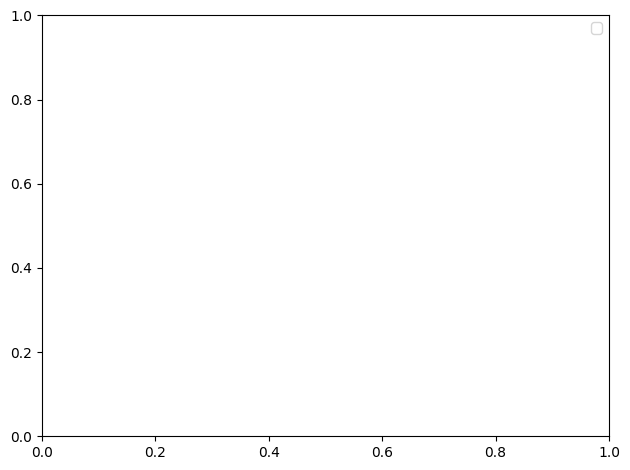

In [27]:
def update(frame):
    x = positions[0][frame].item()
    y = positions[1][frame].item()
    z = positions[2][frame].item()

    satellite_dot.set_data([x], [y])
    satellite_dot.set_3d_properties([z])

    path_line.set_data(positions[0][:frame], positions[1][:frame])
    path_line.set_3d_properties(positions[2][:frame])

    return satellite_dot, path_line

ani = FuncAnimation(fig, update, frames=len(minutes), interval=100, blit=True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Inisialisasi titik satelit dan garis lintasan
satellite_dot, = ax.plot([], [], [], 'ro', label='Iridium 33')
path_line, = ax.plot([], [], [], 'r--', linewidth=0.5, alpha=0.7, label='Lintasan')


<ipython-input-29-a140b03f3a4c>:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


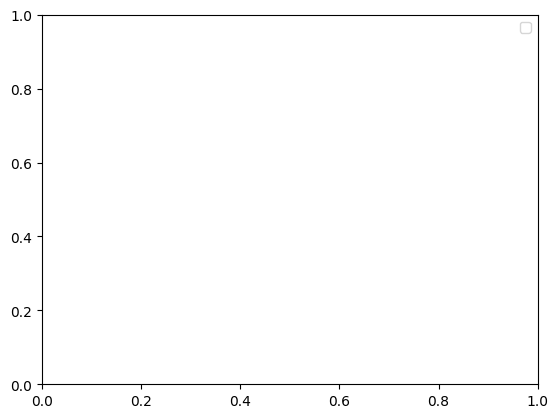

In [29]:
plt.legend()

<ipython-input-30-3f97261511bb>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


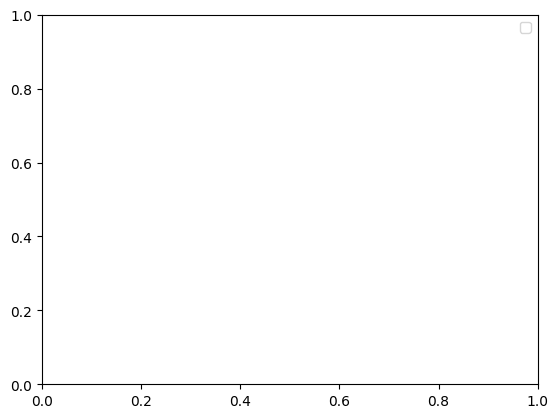

In [30]:
ax.plot([], [], [], 'ro', label='Iridium 33')
ax.plot([], [], [], 'r--', label='Lintasan')

plt.legend()


<ipython-input-31-21e3394eb342>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


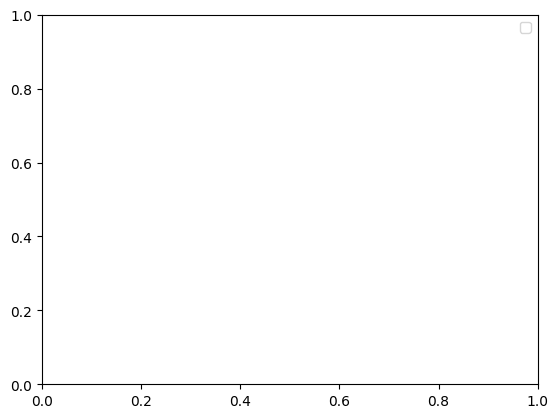

In [31]:
# Tambahkan dummy plot untuk legend (hanya sekali)
ax.plot([], [], [], 'ro', label='Iridium 33')
ax.plot([], [], [], 'r--', label='Lintasan')

plt.legend()


<ipython-input-32-b93ba24ef06d>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


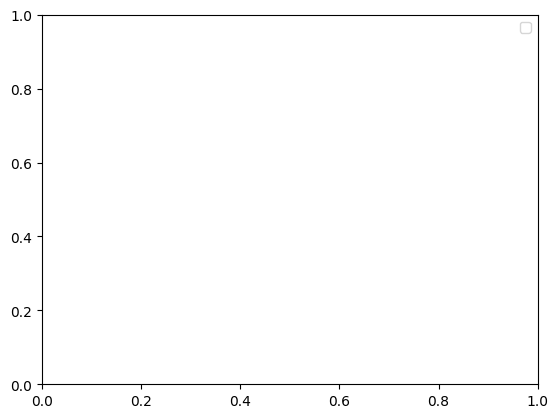

In [32]:
# Inisialisasi titik dan lintasan dengan label
satellite_dot, = ax.plot([], [], [], 'ro', label='Iridium 33')
path_line, = ax.plot([], [], [], 'r--', linewidth=0.5, alpha=0.7, label='Lintasan')

plt.legend()


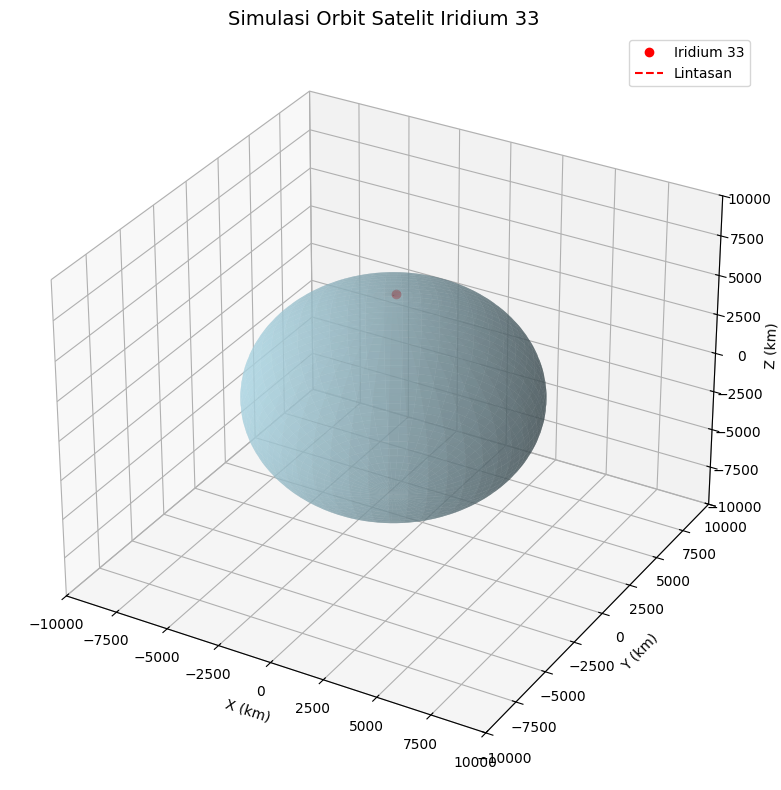

In [33]:
# Data TLE untuk Iridium 33
line1 = "1 24946U 97051C   24143.50347225  .00000096  00000+0  57079-4 0  9993"
line2 = "2 24946  86.3910 167.2371 0003217  88.5513 271.5999 14.63590009814641"
satellite = EarthSatellite(line1, line2, 'IRIDIUM 33')
ts = load.timescale()

# Waktu simulasi selama 90 menit
minutes = np.arange(0, 90, 1)
times = ts.utc(2024, 5, 23, 0, minutes)

# Ambil posisi XYZ satelit terhadap pusat Bumi
positions = satellite.at(times).position.km  # shape: (3, len(minutes))

# Setup plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Simulasi Orbit Satelit Iridium 33', fontsize=14)

# Gambar bola Bumi
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
earth_x = 6371 * np.outer(np.cos(u), np.sin(v))
earth_y = 6371 * np.outer(np.sin(u), np.sin(v))
earth_z = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(earth_x, earth_y, earth_z, color='lightblue', alpha=0.6)

# Batas axis
limit = 10000  # km
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')

# Dummy plot agar legend muncul
ax.plot([], [], [], 'ro', label='Iridium 33')
ax.plot([], [], [], 'r--', label='Lintasan')
plt.legend()

# Inisialisasi titik dan garis lintasan
satellite_dot, = ax.plot([], [], [], 'ro')
path_line, = ax.plot([], [], [], 'r--', linewidth=0.7)

# Fungsi update animasi
def update(frame):
    x = positions[0][frame].item()
    y = positions[1][frame].item()
    z = positions[2][frame].item()

    satellite_dot.set_data([x], [y])
    satellite_dot.set_3d_properties([z])

    path_line.set_data(positions[0][:frame], positions[1][:frame])
    path_line.set_3d_properties(positions[2][:frame])

    return satellite_dot, path_line

# Jalankan animasi
ani = FuncAnimation(fig, update, frames=len(minutes), interval=100, blit=True)
plt.tight_layout()
plt.show()


In [34]:
pip install skyfield matplotlib


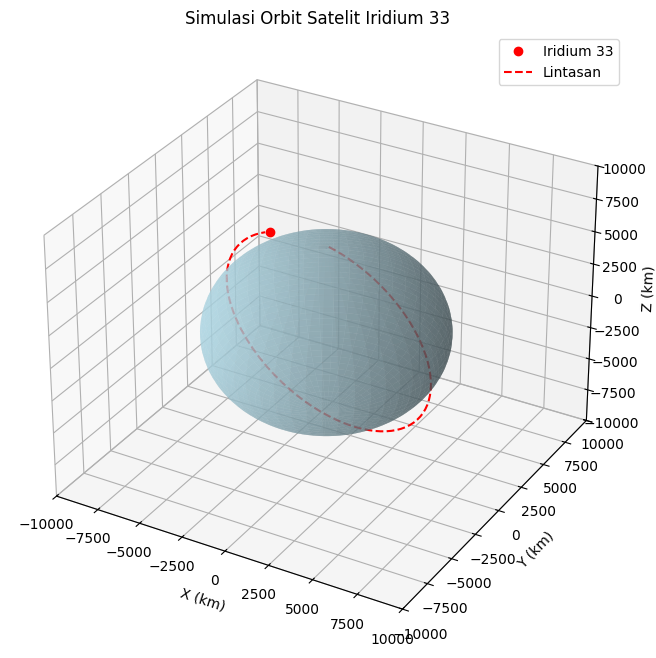

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
from skyfield.api import load, EarthSatellite

# Data TLE Iridium 33
line1 = "1 24946U 97051C   24143.50347225  .00000096  00000+0  57079-4 0  9993"
line2 = "2 24946  86.3910 167.2371 0003217  88.5513 271.5999 14.63590009814641"
satellite = EarthSatellite(line1, line2, 'IRIDIUM 33')
ts = load.timescale()

# Simulasi 90 menit
minutes = np.arange(0, 90, 1)
times = ts.utc(2024, 5, 23, 0, minutes)
positions = satellite.at(times).position.km

# Setup plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Simulasi Orbit Satelit Iridium 33')

# Gambar Bumi
u, v = np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100)
x = 6371 * np.outer(np.cos(u), np.sin(v))
y = 6371 * np.outer(np.sin(u), np.sin(v))
z = 6371 * np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(x, y, z, color='lightblue', alpha=0.6)

# Axis dan legend
ax.set_xlim([-10000, 10000])
ax.set_ylim([-10000, 10000])
ax.set_zlim([-10000, 10000])
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.plot([], [], [], 'ro', label='Iridium 33')
ax.plot([], [], [], 'r--', label='Lintasan')
ax.legend()

# Inisialisasi animasi
satellite_dot, = ax.plot([], [], [], 'ro')
path_line, = ax.plot([], [], [], 'r--')

def update(frame):
    x, y, z = positions[0][frame], positions[1][frame], positions[2][frame]
    satellite_dot.set_data([x], [y])
    satellite_dot.set_3d_properties([z])
    path_line.set_data(positions[0][:frame], positions[1][:frame])
    path_line.set_3d_properties(positions[2][:frame])
    return satellite_dot, path_line

ani = FuncAnimation(fig, update, frames=len(minutes), interval=100, blit=True)

# Simpan ke MP4
writer = FFMpegWriter(fps=10, bitrate=1800)
ani.save("simulasi_iridium33.mp4", writer=writer)
